In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total de notícias: 2979
🔄 Processando lote 1-100 de 2979...
✅ Progresso salvo: 100/2979
🔄 Processando lote 101-200 de 2979...
✅ Progresso salvo: 200/2979
🔄 Processando lote 201-300 de 2979...
✅ Progresso salvo: 300/2979
🔄 Processando lote 301-400 de 2979...
✅ Progresso salvo: 400/2979
🔄 Processando lote 401-500 de 2979...
✅ Progresso salvo: 500/2979
🔄 Processando lote 501-600 de 2979...
✅ Progresso salvo: 600/2979
🔄 Processando lote 601-700 de 2979...
✅ Progresso salvo: 700/2979
🔄 Processando lote 701-800 de 2979...
✅ Progresso salvo: 800/2979
🔄 Processando lote 801-900 de 2979...
✅ Progresso salvo: 900/2979
🔄 Processando lote 901-1000 de 2979...
✅ Progresso salvo: 1000/2979
🔄 Processando lote 1001-1100 de 2979...
✅ Progresso salvo: 1100/2979
🔄 Processando lote 1101-1200 de 2979...
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'
Erro: 'choices'

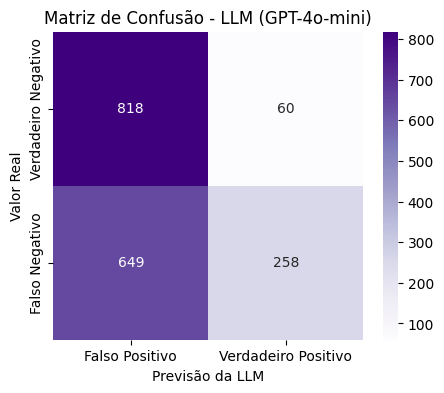

In [ ]:
from openai import OpenAI
import pandas as pd
import numpy as np
import time, asyncio, aiohttp, nest_asyncio, os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cria o cliente da API e variáveis principais
client = OpenAI(api_key="chave")
csv_path = "/content/drive/MyDrive/Portugues/test_dataset.csv"
output_path = "/content/resultados_llm.csv"
modelo = "gpt-4o-mini"

# Lê o dataset e exibe quantas notícias tem
df = pd.read_csv(csv_path, sep=";", encoding="utf-8")
print(f"Total de notícias: {len(df)}")

# envia cada texto p gpt
#retorna 1 ou 0
async def classificar(session, texto):
    prompt = f"""
    Classifique o seguinte texto de notícia como REAL ou FAKE.
    Responda com uma palavra: REAL ou FAKE.
    Texto: "{texto}"
    """
    try:
        async with session.post(
            "https://api.openai.com/v1/chat/completions",
            headers={"Authorization": f"Bearer {client.api_key}"},
            json={
                "model": modelo,
                "messages": [{"role": "user", "content": prompt}],
                "temperature": 0  # evita respostas aleatórias
            },
            timeout=60
        ) as resp:
            data = await resp.json()
            resposta = data["choices"][0]["message"]["content"].strip().upper()
            if resposta not in ["REAL", "FAKE"]:
                resposta = "FAKE"
            return 0 if resposta == "FAKE" else 1
    except Exception as e:
        print("Erro:", e)
        return np.nan  # retorna nulo se algo falhar

# Corrige possíveis conflitos de loop assíncrono
nest_asyncio.apply()

# processa o dataset em lotes pra nao gastar toda ram do colab, salva progresso e evita reprocessar textos
async def processar_em_lotes(df, batch_size=100):
    resultados = []
    start = 0
    total = len(df)

    # Retoma o progresso se um arquivo parcial já existir
    if os.path.exists(output_path):
        prev = pd.read_csv(output_path)
        start = len(prev)
        resultados = prev["predito"].tolist()
        print(f"Retomando {start}/{total}...")

    async with aiohttp.ClientSession() as session:
        for i in range(start, total, batch_size):
            fim = min(i + batch_size, total)
            batch = df.iloc[i:fim]["texto"].tolist()
            print(f"Processando  {i+1}-{fim} de {total}...")

            # Cria tarefas p cada texto e coleta respostas
            tasks = [classificar(session, t) for t in batch]
            batch_preds = await asyncio.gather(*tasks)
            resultados.extend(batch_preds)

            # Salva o progresso a cada lote processado
            pd.DataFrame({
                "texto": df.iloc[:fim]["texto"],
                "label": df.iloc[:fim]["label"],
                "predito": resultados
            }).to_csv(output_path, index=False)
            print(f"salvo: {fim}/{total}")

            time.sleep(2)  # pausa p evitar sobrecarga API
    return resultados

# processamento completo do dataset
preds = asyncio.run(processar_em_lotes(df))

# Remove previsões inválidas e calcula métricas
validos = [i for i in range(len(preds)) if not np.isnan(preds[i])]
y_true = df.iloc[validos]["label"].values
preds_validos = np.array(preds)[validos]

print("\nAcurácia:", round(accuracy_score(y_true, preds_validos), 4))
print("\nClassificação:")
print(classification_report(y_true, preds_validos, target_names=["FAKE", "REAL"]))


cm = confusion_matrix(y_true, preds_validos)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Falso Positivo", "Verdadeiro Positivo"],
            yticklabels=["Verdadeiro Negativo", "Falso Negativo"])
plt.title("Matriz de Confusão - LLM (GPT-4o-mini)")
plt.xlabel("Previsão da LLM")
plt.ylabel("Valor Real")
plt.show()
